In [1]:
import torch
import pyro
from pyro.distributions import *
#from collections import Counter
import pyro.infer
import pyro.optim
pyro.enable_validation(True)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

import random

import numpy as np
import pandas as pd
import scipy.stats as stats

import utils

In [2]:
# set a random seed
random.seed(1625)

# fix the range of pitches we consider
fifth_range = 2*7                  # 2 diatonics
npcs = 2*fifth_range+1             # around C: Cbb to C## on LoF
utils.set_fifth_range(fifth_range) # used to make helper functions work correctly

# A Cognitive Model or Harmonic Types

## Model

A chord consists of a number of notes,
which are either generated as stable chord tones or as ornaments.
We model this process by distinguishing (for each chord type)
a distribution of chord tones and a distribution of ornaments.
For each generated note, a coin is flipped as to whether the tone is generated as a chord tone or ornament.
The pitch is then drawn from the corresponding distribution.
Since we don't always know the type of a note, we flip another coin to decide whether the type is observed or not (in which case `unknown` is emitted for both ornaments and chordtones).

Priors:
- choose $\vec\chi \sim \text{Dirichlet}(0.5, n_\text{harmonies})$
- choose $\theta \sim \text{Beta}(1,1)$
- choose $\lambda \sim \text{Gamma}(3,1)$
- for each chord type $i$
  - choose $\vec\phi_{ct}^{(i)} \sim \text{Dirichlet}(0.5, n_\text{pitches})$
  - choose $\vec\phi_{or}^{(i)} \sim \text{Dirichlet}(0.5, n_\text{pitches})$

Generating a single chord (long version):
- choose $h \sim \text{Categorical}(\vec\chi)$
- choose $n \sim \text{Poisson}(\lambda) + 1$
- for each note $i \in 1, \ldots, n$:
  - choose $t_i \sim \text{Bernoulli}(\theta)$
  - choose $p_i \sim \begin{cases}
                       \text{Categorical}(\vec\phi_{ct}^{(h)}) & \text{if } t_i = 1\\
                       \text{Categorical}(\vec\phi_{or}^{(h)}) & \text{if } t_i = 0
                     \end{cases}$
  - choose $o_i \sim \text{Bernoulli}(p_\text{obs})$
  - choose $ot_i = \begin{cases}
                     \text{'chordtone'} & \text{if } o_i = 1 \wedge p_i = 1\\
                     \text{'ornament'} & \text{if } o_i = 1 \wedge p_i = 0\\
                     \text{'unknown'} & \text{if } o_i = 0\\
                   \end{cases}$
- count $(p_i,ot_i)$ pairs

Generating a single chord (compact version)
- choose $h \sim \text{Catecorical}(\vec\chi)$
- choose $n \sim \text{Poisson}(\lambda) + 1$
- choose $n_{p,ot} \sim \text{Multinomial}(n, \vec\nu),$ where
  - $\nu_{ct} = p_\text{obs} \cdot \theta \cdot \vec\phi_{ct}^{(h)}$
  - $\nu_{or} = p_\text{obs} \cdot (1-\theta) \cdot \vec\phi_{or}^{(o)}$
  - $\nu_{uk} = (1-p_\text{obs}) \cdot \left( \theta \vec\phi_{ct}^{(h)} + (1-\theta) \vec\phi_{or}^{(h)} \right)$
  - $\nu = \text{concat}(\nu_{ct}, \nu_{or}, \nu_{uk})$

In [3]:
def chord_model(npcs, nharmonies, data, subsamples=500, pobserve=0.5, **kwargs):    
    # parameters priors:
    # distribution of the harmonies
    p_harmony = pyro.sample('p_harmony', Dirichlet(0.5 * torch.ones(nharmonies)))
    # distribution of notes in the harmonies
    with pyro.plate('harmonies', nharmonies) as ind:
        # distribution of ornament probability
        p_is_chordtone = pyro.sample('p_is_chordtone', Beta(torch.ones(nharmonies), torch.ones(nharmonies)))
        #print(p_is_chordtone.shape)
        # distribution of notes per note type
        p_chordtones = pyro.sample('p_chordtones', Dirichlet(0.5 * torch.ones(npcs)))
        p_ornaments  = pyro.sample('p_ornaments', Dirichlet(0.5 * torch.ones(npcs)))
        #print(p_chordtones.shape)
        # we build a big categorical out of the chordtones and ornaments,
        # including notes of unknown type (marginalizing over the categories)
        #p_ct = p_is_chordtone       * p_chordtones
        #p_or = (1 - p_is_chordtone) * p_ornaments
        p_ct = torch.mm(torch.diag(p_is_chordtone), p_chordtones)
        p_or = torch.mm(torch.diag(1 - p_is_chordtone), p_ornaments)
        p_unobserved = p_ct + p_or
        p_tones = torch.cat([pobserve * p_ct, pobserve * p_or, (1-pobserve) * p_unobserved], dim=1)
    # distribution of note rate in chords
    rate_notes = pyro.sample('rate_notes', Gamma(3,1))
    
    # sampling the data:
    nchords = len(data['c'])
    with pyro.plate('data', nchords, subsample_size=min(nchords,subsamples)) as ind:
        # pick a harmony
        c = pyro.sample('c', Categorical(p_harmony), obs=data['c'][ind])
        # pick a number of notes
        nnotes = 1 + pyro.sample('n', Poisson(rate_notes), obs=data['n'][ind]).int()
        # sample chordtones
        # Normally we would sample nnotes notes for each chord, but that doesn't work vectorized.
        # However, evaluating the probability ignores n, so we can just provide 1 here.
        notes = pyro.sample('chord', Multinomial(1, p_tones[c], validate_args=False), obs=data['notes'][ind])
        chords = {'c': c,
                  'n': nnotes,
                  'counts': notes.reshape(-1,npcs)}
    return chords

## Guide

A simple guide that assumes the latent variables to be distributed independently.

In [36]:
def chord_guide(npcs, nharmonies, data, subsamples=500, pobserve=0.5, init=dict()):
    # posterior of p_harmony
    params_p_harmony = pyro.param('params_p_harmony',
                                  init['harmonies'] if 'harmonies' in init else 0.5 * torch.ones(nharmonies),
                                  constraint=constraints.positive)
    pyro.sample('p_harmony', Dirichlet(params_p_harmony))
    
    # posteriors of notes dists in harmonies (parameters)
    params_p_chordtones = pyro.param('params_p_chordtones',
                                     init['chordtones'] if  'chordtones' in init else 0.5 * torch.ones(npcs),
                                     constraint=constraints.positive)
    params_p_ornaments = pyro.param('params_p_ornaments',
                                     init['ornaments'] if 'ornaments' in init else 0.5 * torch.ones(npcs),
                                    constraint=constraints.positive)
    
    # posterior of ornament probability (parameters)
    alpha_p_ict = pyro.param('alpha_p_ict',
                             init['is_ct'] if 'is_ct' in init else torch.ones(nharmonies),
                             constraint=constraints.positive)
    beta_p_ict = pyro.param('beta_p_ict',
                            init['is_or'] if 'is_or' in init else torch.ones(nharmonies),
                            constraint=constraints.positive)
    
    # posteriors of ornament probability and note distributions
    with pyro.plate('harmonies', nharmonies) as ind:
        pyro.sample('p_is_chordtone', Beta(alpha_p_ict, beta_p_ict))
        pyro.sample('p_chordtones', Dirichlet(params_p_chordtones))
        pyro.sample('p_ornaments', Dirichlet(params_p_ornaments))
        
    #posterior of note rate
    alpha_rate_notes = pyro.param('alpha_rate_notes',
                                  init['sum_chords'] if 'sum_chords' in init else torch.tensor(3.),
                                  constraint=constraints.positive)
    beta_rate_notes = pyro.param('beta_rate_notes',
                                 init['n_chords'] if 'n_chords' in init else torch.tensor(1.),
                                 constraint=constraints.positive)
    rate_notes = pyro.sample('rate_notes', Gamma(alpha_rate_notes, beta_rate_notes))

## Data and Conditioning

### Data Format

The input data (i.e. the observations that the model is conditioned on) is represented by three tensors:
- `c` for the chord labels (as "categorical" integers)
- `n` for the number of notes in each chord
- `notes` for the observed notes in each chord

Each of these tensors represents the values for all chords at the same time (i.e. a *vectorized* representation),
so the first dimension of each equals `nchords`, the number of chords.
`c` and `n` are vectors, i.e. their value for each chord is a scalar.
`notes` represents a vector for each chord that contains the counts of all pitch $\times$ note type pairs in the chord.
If we assume 29 pitch classes, we therefore have 87 entries: 29 for the chordtones, 29 for the ornaments, and 29 for the notes of unknown type.
As a result, `notes` has dimension `nchords` $\times$ 87.

The values of `c` represent each chord's type, which is distributed according to a categorical distribution.
In pyro/torch, categories are represented as integers, so we must convert textual labels into integers.
Similarly, the index of a note in `notes` is determined by it's pitch class and type (as outlined above).
While we allow negative pitch classes, they can be easily transformed into indices (and *vice versa*) by shifting all values by `npcs // 2`.

In [5]:
def chord_tensor(notes):
    """Takes a list of notes as (fifth, type) pairs and returns a vector of counts."""
    notetype = {'chordtone': 0, 'ornament': 1, 'unknown': 2}
    chord = torch.zeros((3, npcs))
    for (fifth, t) in notes:
        chord[notetype[t], utils.fifth_to_index(fifth)] += 1
    return chord

def annot_data_obs(chords):
    """Helper function to turn a list of chord dictionary into a dictionary of observation vectors."""
    obs = {}
    obs["notes"] = torch.cat([chord_tensor(c['notes']).reshape((1,-1)) for c in chords], dim=0)
    obs["c"] = torch.tensor([c['label'] for c in chords])
    obs["n"] = torch.tensor([len(c['notes']) - 1. for c in chords])
    return obs

### Loading the Dataset

The data is loaded from a TSV file that.
The resulting dataframe is converted to the observation format that we pass to the model.

In [6]:
def load_dataset(filename):
    print("loading dataset...")
    df = utils.load_csv(filename)
    sizes = df.groupby(['chordid', 'label']).size()
    type_counts = sizes.groupby('label').size().sort_values(ascending=False)
    chordtypes = type_counts.index.tolist()
    df['numlabel'] = df.label.map(chordtypes.index)
    print('extracting chords...')
    chords = [{'label': label, 'notes': list(zip(grp.fifth, grp.type))}
              for (_, label), grp in tqdm.tqdm(df.groupby(['chordid', 'numlabel']))]
    print('converting chords to tensors...')
    obs = annot_data_obs(chords)
    print(len(chordtypes), "chord types")
    print(len(chords), "chords")
    return df, obs, chordtypes

In [27]:
def get_init_params(df, nharms, npcs):
    init = dict()
    
    init['harmonies'] = torch.tensor(df.groupby('numlabel').size().sort_values()) + 0.5

    init['chordtones'] = torch.zeros([nharms,npcs]) + 0.5
    for (numlabel, fifth), grp in df[df.type=='chordtone'].groupby(['numlabel','fifth']):
        init['chordtones'][numlabel, utils.fifth_to_index(fifth)] += grp.fifth.count()

    init['ornaments'] = torch.zeros([nharms,npcs]) + 0.5
    for (numlabel, fifth), grp in df[df.type=='ornament'].groupby(['numlabel','fifth']):
        init['ornaments'][numlabel, utils.fifth_to_index(fifth)] += grp.fifth.count()
    
    init['is_ct'] = torch.tensor([sum(df[df.numlabel==l].type=='chordtone') for l in range(nharms)]) + 1
    #torch.tensor(sum(df.type=='chordtone') + 1)
    init['is_or'] = torch.tensor([sum(df[df.numlabel==l].type=='ornament') for l in range(nharms)]) + 1
    #torch.tensor(sum(df.type=='ornament') + 1)
    
    chord_sizes = df.groupby('chordid').size()-1
    init['sum_chords'] = torch.tensor(sum(chord_sizes) + 3)
    init['n_chords'] = torch.tensor(len(chord_sizes) + 1)
    return init

## Inference

Inference of the posterior is done via variational inference, i.e. by optimizing the parameters of the guide.
The function `infer_posteriors` takes a dataset of observations,
performs the optimization, and returns the optimized parameters together with some of their histories.

In [8]:
def infer_posteriors(obs, init, nharms, nsteps=5_000, subsamples=10_000, plot_loss=True, save_as=None):
    # optimize the parameters of the guide
    pyro.clear_param_store()
    svi = pyro.infer.SVI(model=chord_model,
                         guide=chord_guide,
                         optim=pyro.optim.Adam({"lr": 0.01, "betas": (0.95, 0.999)}),
                         #optim=pyro.optim.Adadelta({"lr": 1.0, "rho": 0.9}),
                         #optim=pyro.optim.SGD({"lr": 0.00005, "momentum": 0.9, "nesterov": True}),
                         loss=pyro.infer.Trace_ELBO())

    # configuration values
    # nsteps = 5_000
    # subsamples = 10_000 # 10_000 is pretty fast (~15 it/s), but lower values are fine wrt. variance

    # set up histories for the loss and some of the parameters
    losses = np.zeros(nsteps)
    param_history = {name:np.zeros(nsteps) for name in ['alpha_rate_notes', 'beta_rate_notes']}#, 'alpha_p_ict', 'beta_p_ict']}
    root_history = np.zeros((nsteps,nharms))

    # run the optimization
    for i in tqdm.trange(nsteps):
        losses[i] = svi.step(npcs, nharms, obs, subsamples, init=init)
        ps = pyro.get_param_store()
        root_history[i] = ps.get_param('params_p_chordtones').detach()[:,fifth_range]
        for (name, value) in ps.items():
            if name in param_history:
                param_history[name][i] = value.item()

    # plot the loss
    if plot_loss:
        plt.figure()
        plt.plot(losses)
        plt.xlabel("iteration")
        plt.ylabel("loss")
        plt.show()
    
    params = dict((name, value.detach()) for name, value in pyro.get_param_store().items())
    if save_as != None:
        torch.save(params, save_as)
    
    return params, param_history, root_history

To inspect the results and the behaviour of the optimization, we define some functions for plotting parameter histories and posterior distributions.

In [9]:
# histories

def plot_param_history(history):
    df = pd.DataFrame(history)
    df.plot()
    plt.xlabel("iteration")
    plt.show()
    
def plot_roots(root_history):
    plt.plot(root_history)
    plt.xlabel("iteration")
    plt.show()

def plot_histories(param_history, root_history):
    plot_param_history(param_history)
    plot_roots(root_history)

In [21]:
# posteriors

# posterior of 'rate_notes'
def plot_note_rate(params):
    alpha = params['alpha_rate_notes']
    beta = params['beta_rate_notes']
    x = np.linspace(5.5,5.7,200)
    y = stats.gamma.pdf(x, alpha, scale=1/beta)
    plt.plot(x,y)
    plt.xlabel('rate_notes')
    plt.show()
    xrate = torch.linspace(0,10,11)
    yrate = stats.nbinom.pmf(xrate, alpha, 1/(1+1/beta))
    plt.bar(xrate+1, yrate)
    plt.xlabel('nnotes')
    plt.show()
    
# posterior of 'p_is_chordtone'
def plot_p_ict(params, harmtypes):
    alphas = params["alpha_p_ict"]
    betas  = params["beta_p_ict"]
    x = torch.linspace(0.7,0.95,100)
    y = np.array([stats.beta.pdf(x, a, b) for a, b in zip(alphas, betas)]).transpose()
    plt.plot(x,y)
    plt.xlabel("p_is_chordtone")
    plt.legend(harmtypes)
    plt.show()

# posterior of chord type probabilities
def plot_chord_type_dist(params, labels):
    plt.figure(figsize=(6,9))
    alphas = params['params_p_harmony']
    plt.barh(np.arange(len(alphas)), alphas, tick_label=labels)
    plt.show()

# posteriors of note probabilities
def plot_chords(params, labels):
    post_chordtones = params['params_p_chordtones']
    post_ornaments = params['params_p_ornaments']
    for i, name in enumerate(labels):
        utils.plot_profile(post_chordtones[i], post_ornaments[i], name)
        utils.play_chord(post_chordtones[i])

# plot all posteriors
def plot_posteriors(params, chordtypes):
    plot_note_rate(params)
    plot_p_ict(params, chordtypes)
    plot_chord_type_dist(params, chordtypes)
    plot_chords(params, chordtypes)

## Experiments

### DCML Corpus

The DCML corpus is a collection of classical pieces with elaborate harmonic annotations.
Here we only distinguish the basic harmonic types defined in the annotation standard (triads and seventh chords),
since the extra information (inversion, suspensions, added notes etc.) do not change the type of the chord.

In [13]:
# prepare the dataset
dcml_df, dcml_obs, dcml_chordtypes = load_dataset('data/dcml.tsv')
dcml_init = get_init_params(dcml_df, len(dcml_chordtypes), npcs)

loading dataset...
extracting chords...


100%|██████████| 157046/157046 [00:43<00:00, 3648.13it/s]


converting chords to tensors...
11 chord types
157046 chords


100%|██████████| 5000/5000 [04:28<00:00, 18.65it/s]


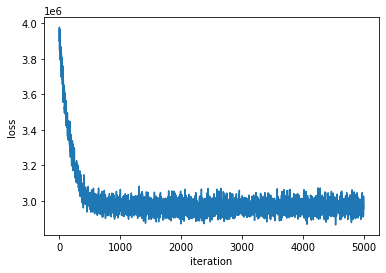

In [43]:
# run the optimization
dcml_params, dhist, droots = infer_posteriors(dcml_obs, dcml_init, len(dcml_chordtypes),
                                              nsteps=5000, save_as="dcml_params.pt")

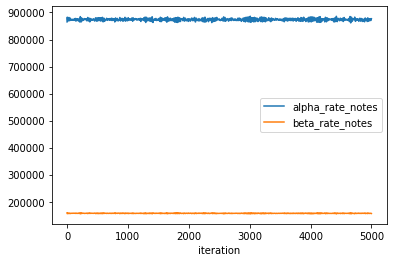

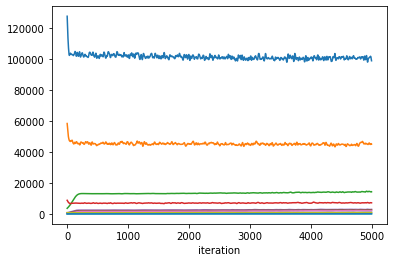

In [44]:
# plot the histories the parameters to check convergence
plot_histories(dhist, droots)

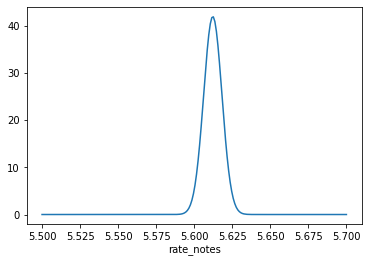

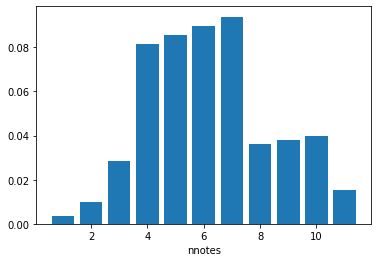

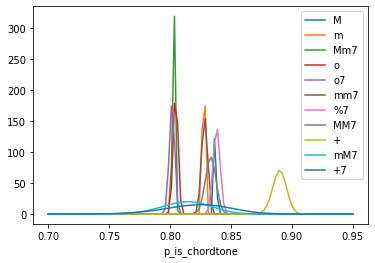

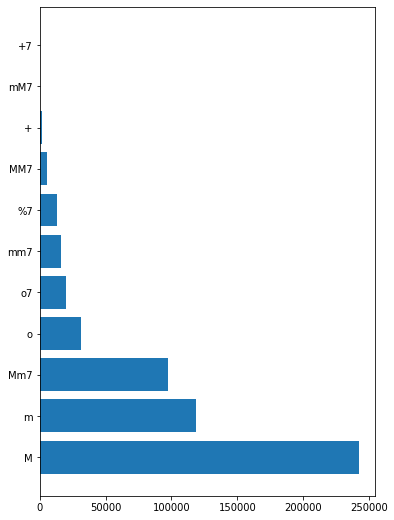

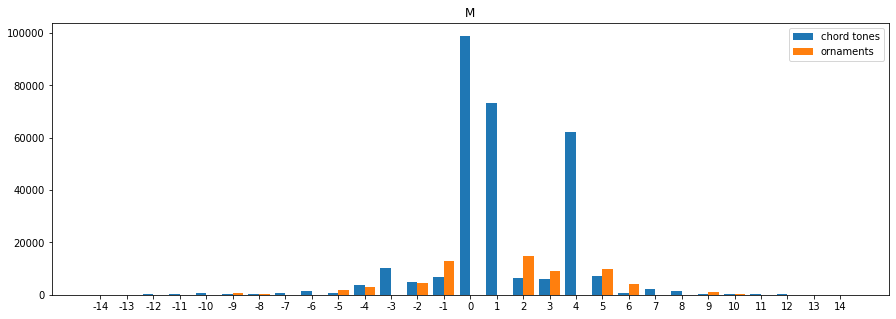

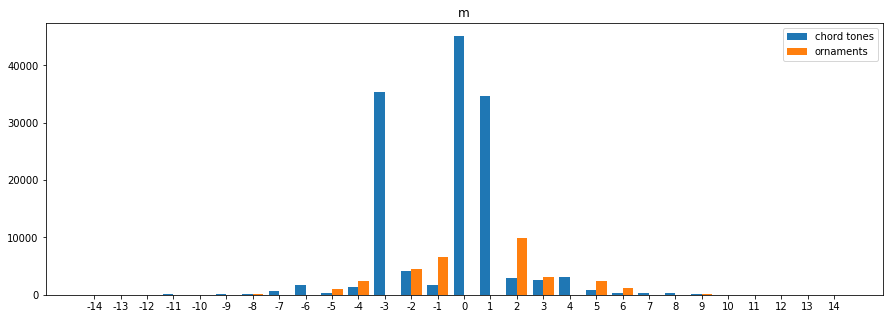

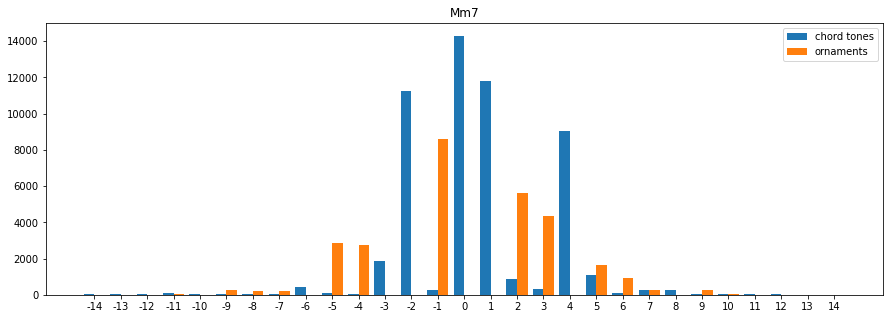

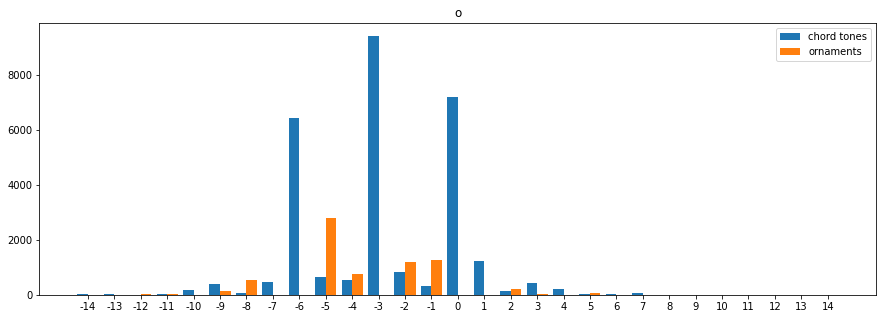

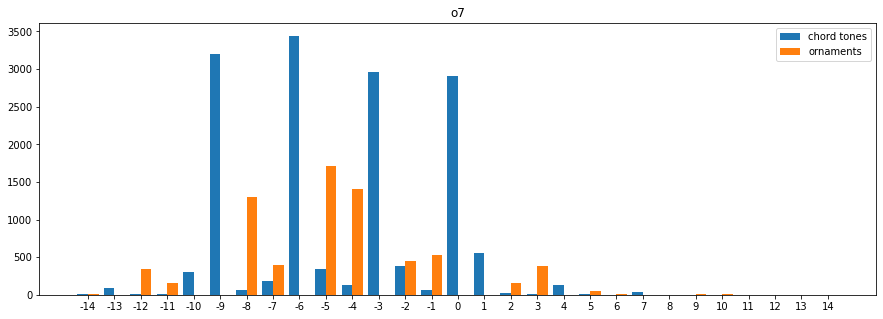

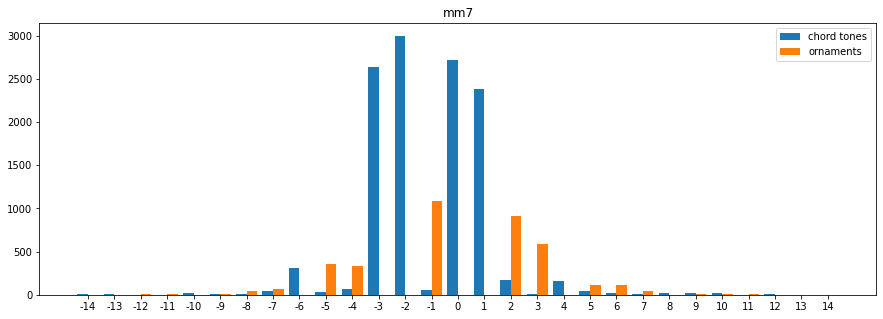

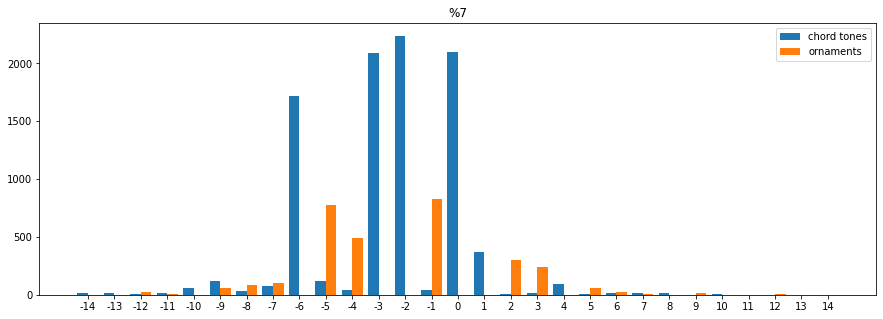

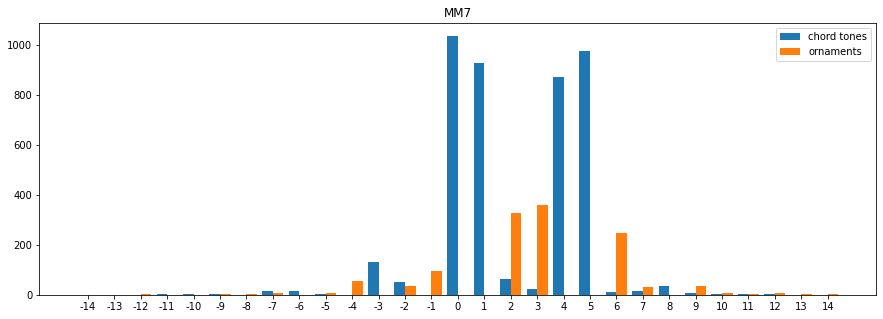

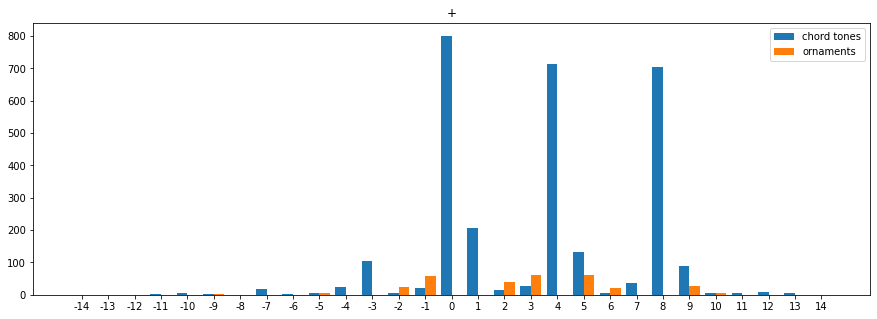

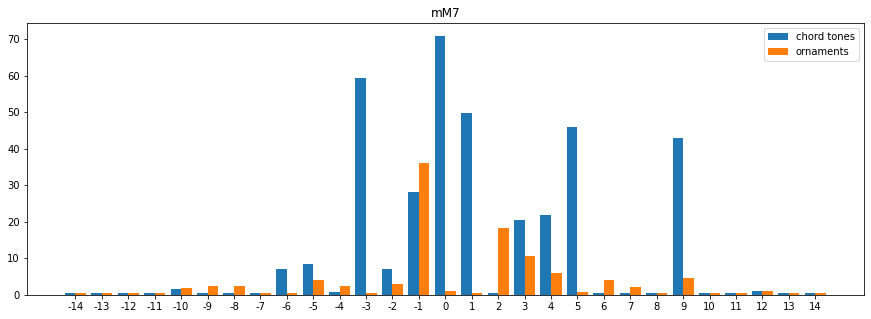

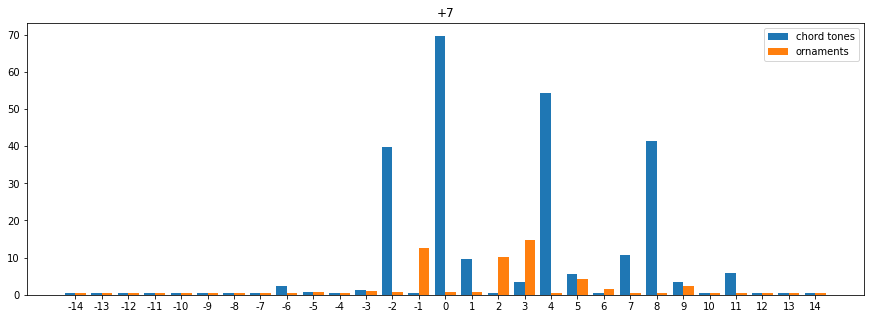

In [45]:
# plot the posterior distributions of the parameters
plot_posteriors(dcml_params, dcml_chordtypes)

### Wikifonia Corpus

The Wikifonia dataset consists of leadsheets, i.e. melodies and chord labels.
It uses the chord types set in the MusicXML source of the chord-labels, which can be quite chaotic.
Therefore, we normalize the chord-types to the ones defined in the MusicXML standard,
removing unclear chord labels (which are rather rare).

In [28]:
# prepare the dataset
wiki_df, wiki_obs, wiki_chordtypes = load_dataset('data/wikifonia.tsv')
wiki_init = get_init_params(wiki_df, len(wiki_chordtypes), npcs)

loading dataset...
extracting chords...


100%|██████████| 257794/257794 [01:12<00:00, 3567.99it/s]


converting chords to tensors...
48 chord types
257794 chords


In [29]:
wiki_init

{'harmonies': tensor([1.5000e+00, 2.5000e+00, 3.5000e+00, 4.5000e+00, 3.0500e+01, 4.5500e+01,
         4.7500e+01, 4.7500e+01, 5.4500e+01, 6.9500e+01, 8.5500e+01, 9.5500e+01,
         1.2350e+02, 1.2850e+02, 1.4250e+02, 1.5150e+02, 1.5950e+02, 1.8150e+02,
         2.0050e+02, 2.8050e+02, 3.6350e+02, 4.1850e+02, 5.1750e+02, 8.0550e+02,
         8.4150e+02, 1.0485e+03, 2.0785e+03, 2.6045e+03, 2.6755e+03, 2.6895e+03,
         2.9315e+03, 3.7595e+03, 3.8095e+03, 4.1135e+03, 4.3065e+03, 5.3455e+03,
         5.6085e+03, 7.8555e+03, 8.4505e+03, 1.0132e+04, 1.1206e+04, 1.5944e+04,
         1.6346e+04, 2.7418e+04, 7.5862e+04, 1.0961e+05, 2.0660e+05, 3.3906e+05]),
 'chordtones': tensor([[ 0.5000,  0.5000,  8.5000,  ..., 36.5000, 26.5000,  4.5000],
         [ 0.5000,  0.5000,  5.5000,  ..., 52.5000, 49.5000,  4.5000],
         [ 0.5000,  0.5000,  1.5000,  ..., 10.5000, 20.5000,  0.5000],
         ...,
         [ 0.5000,  0.5000,  0.5000,  ...,  0.5000,  0.5000,  0.5000],
         [ 0.5000,  0.500

100%|██████████| 5000/5000 [05:12<00:00, 15.99it/s]


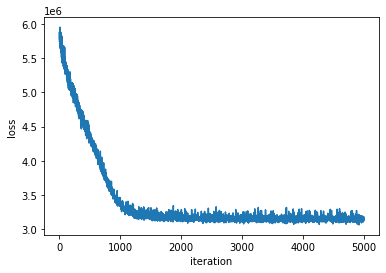

In [46]:
# run the optimization
wiki_params, whist, wroots = infer_posteriors(wiki_obs, wiki_init, len(wiki_chordtypes),
                                              nsteps=5000, save_as="wikifonia_params.pt")

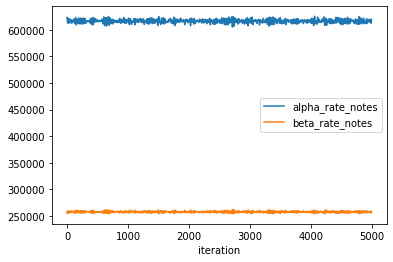

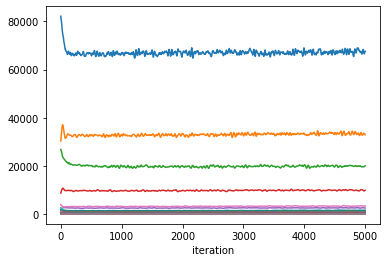

In [47]:
# plot the histories the parameters to check convergence
plot_histories(whist, wroots)

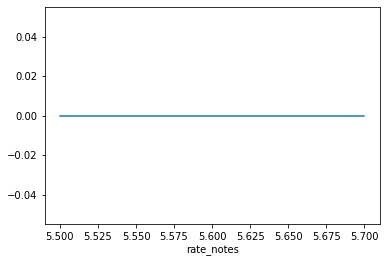

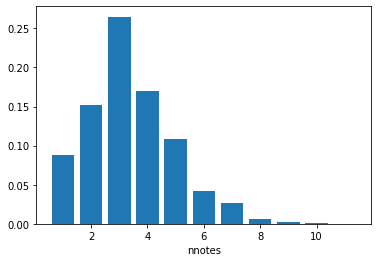

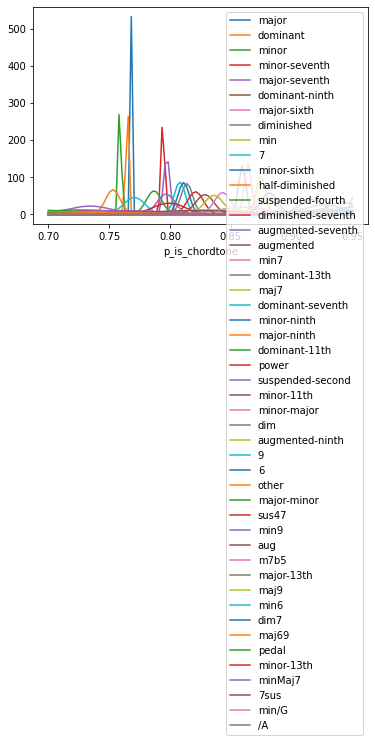

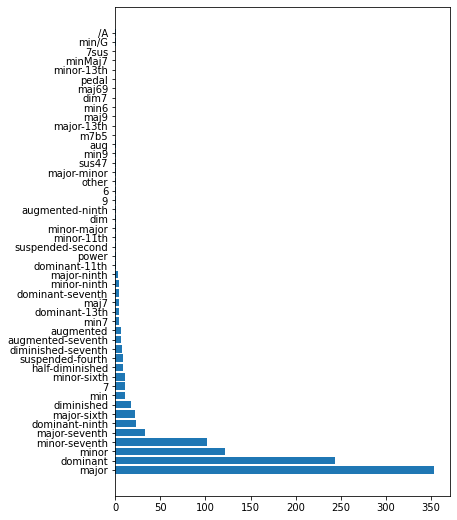

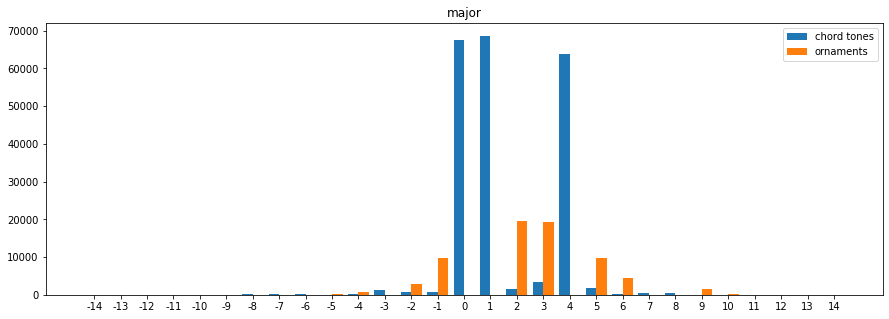

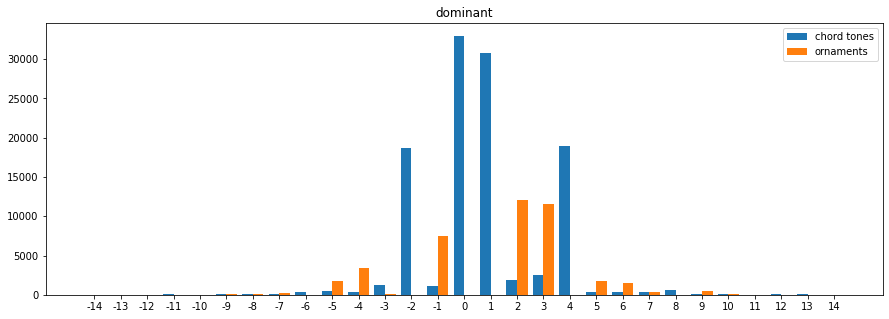

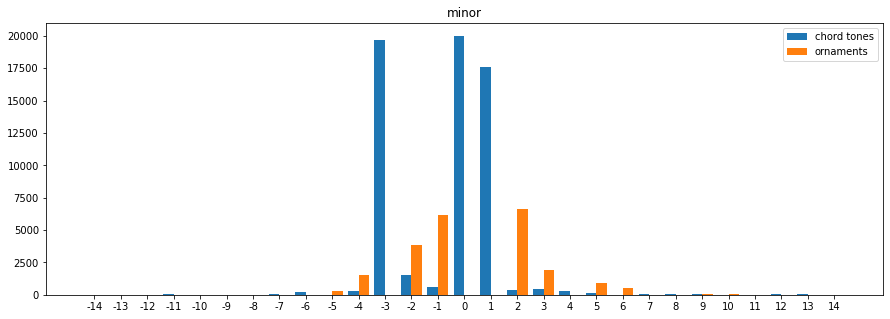

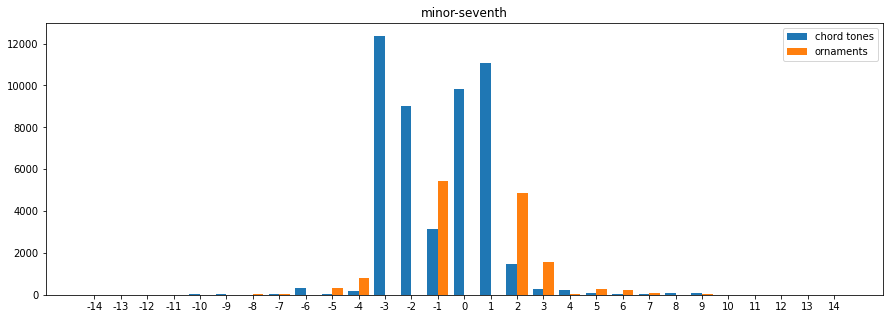

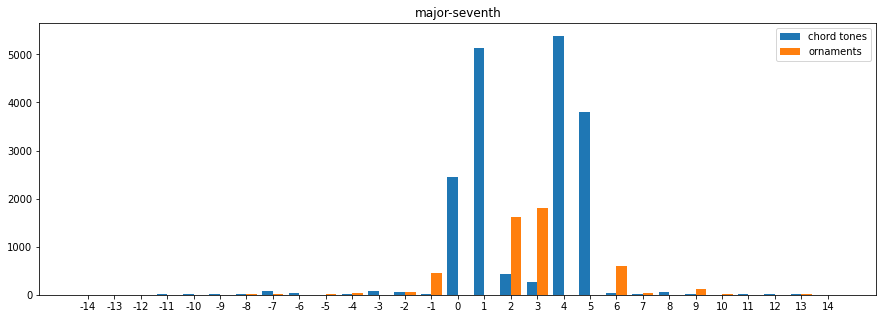

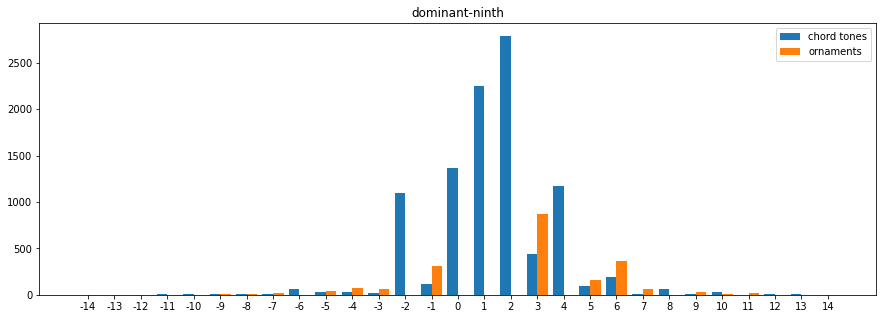

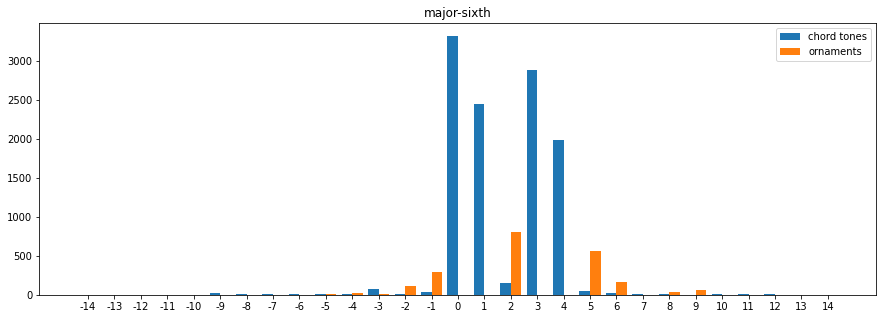

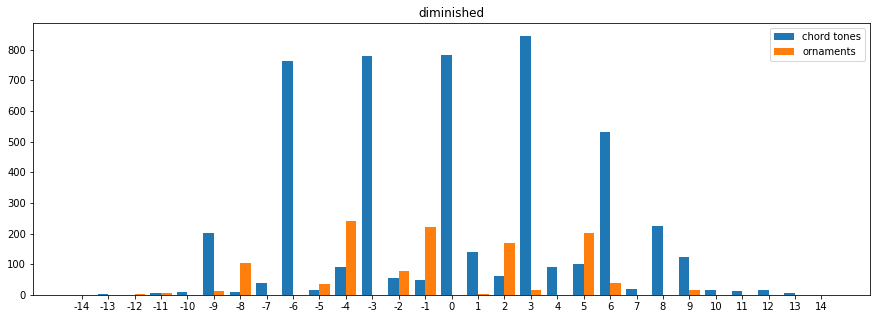

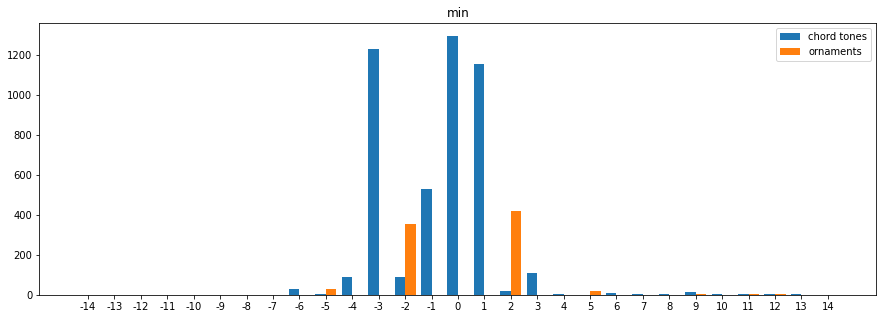

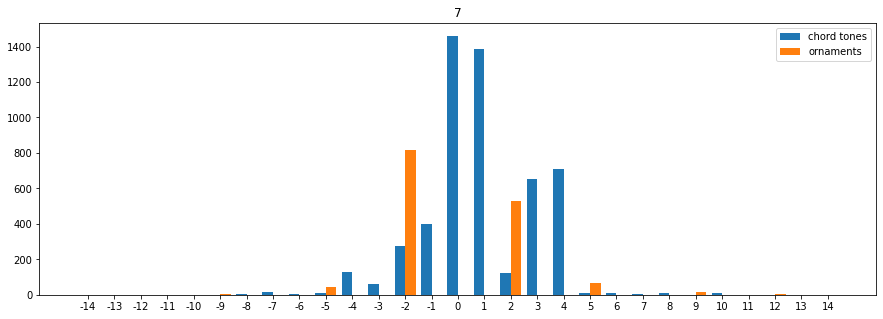

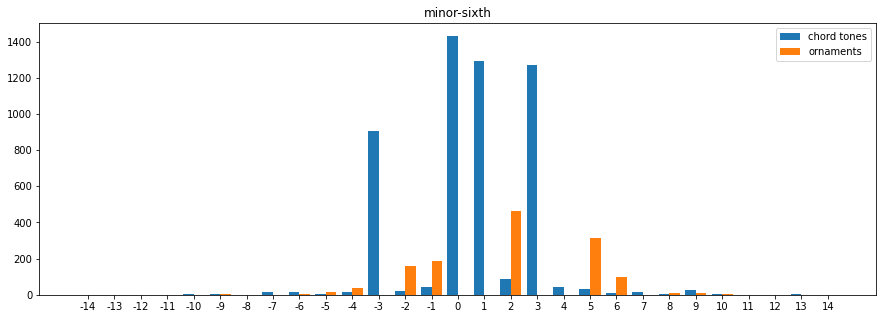

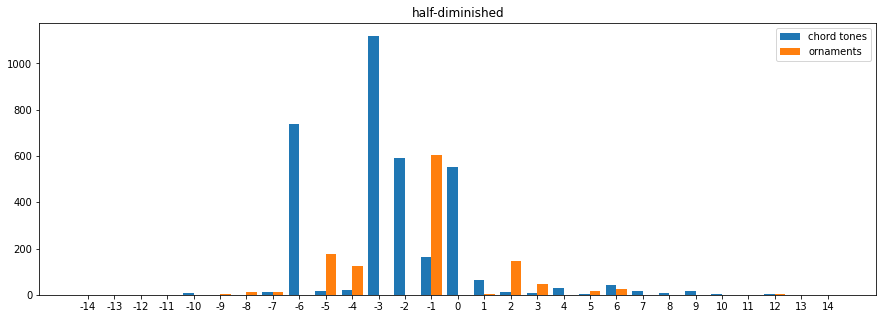

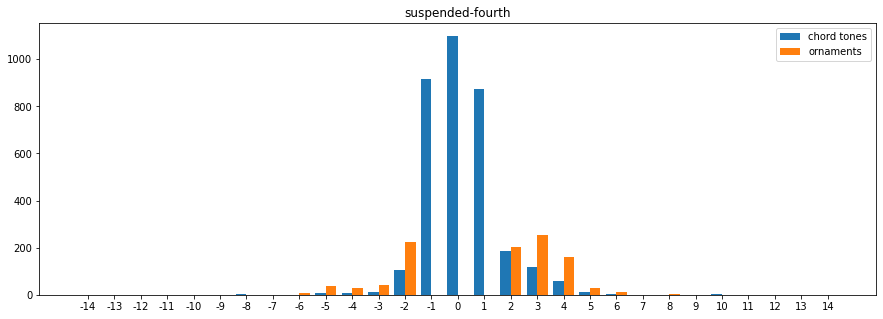

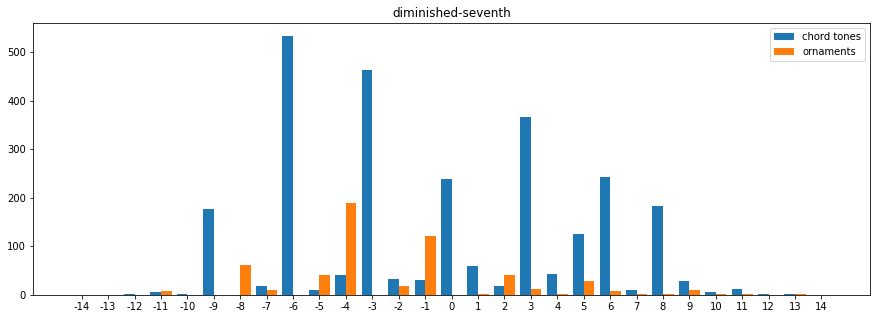

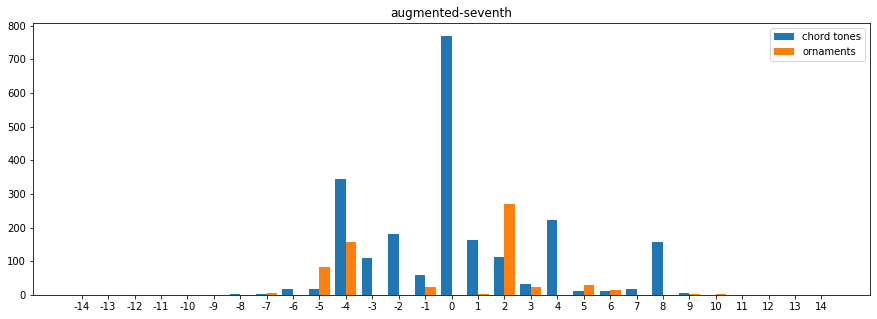

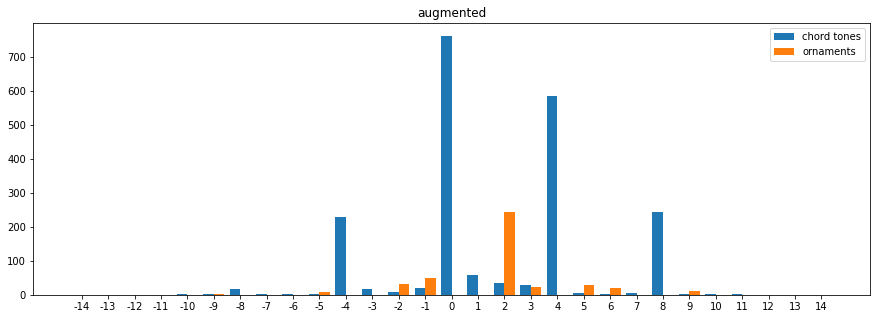

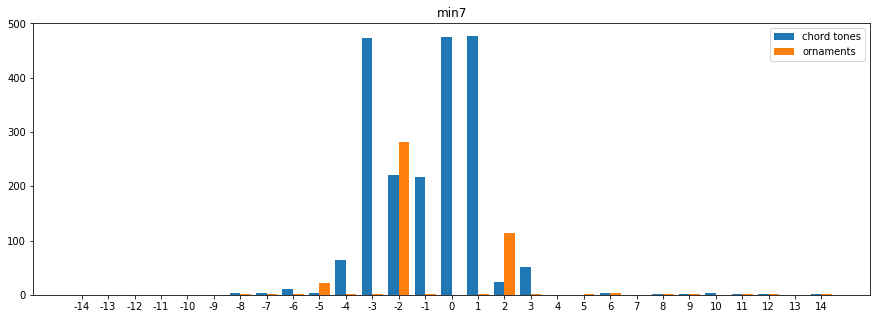

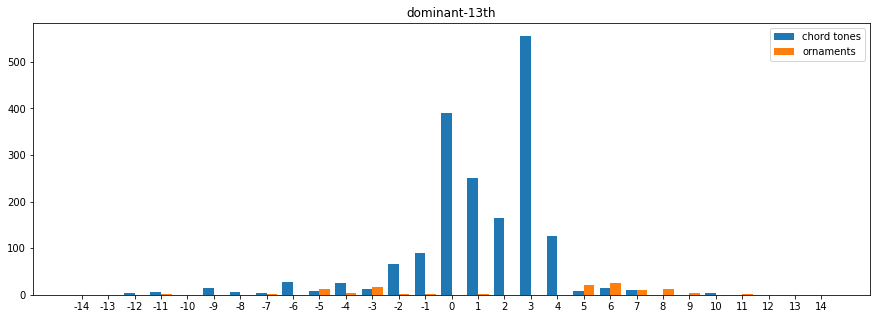

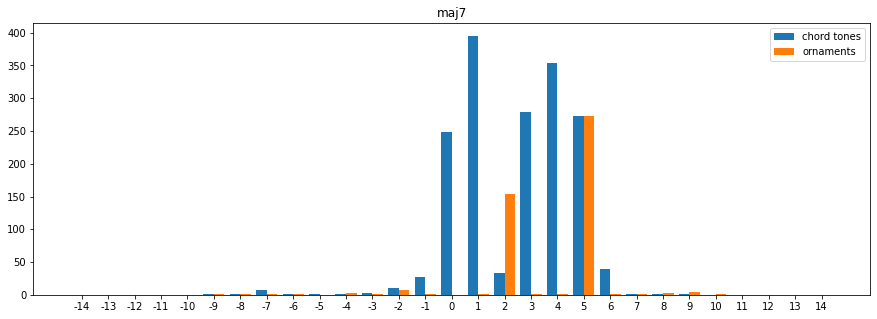

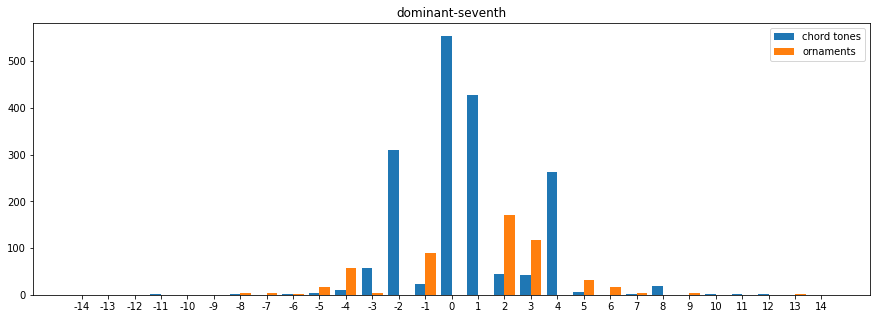

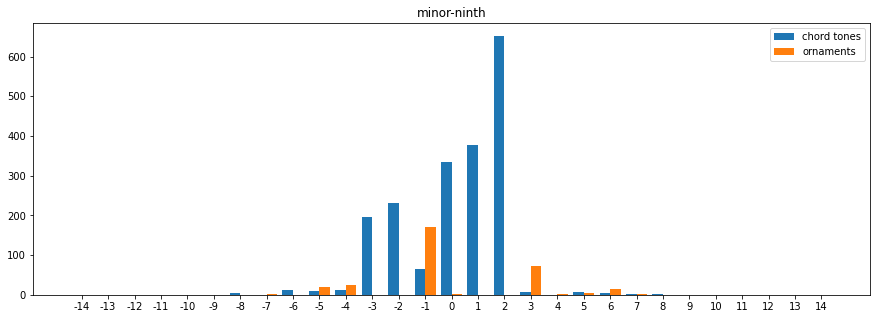

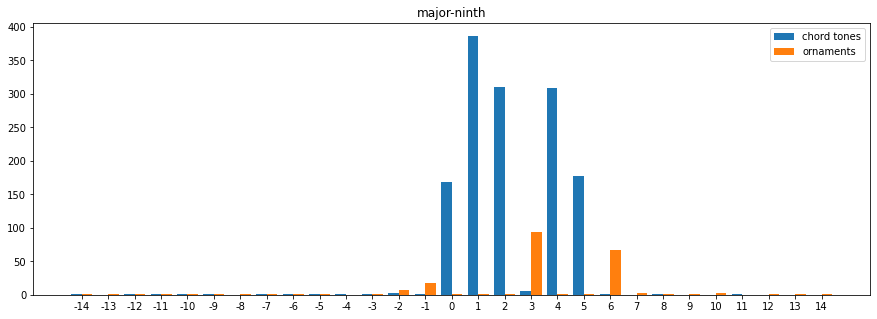

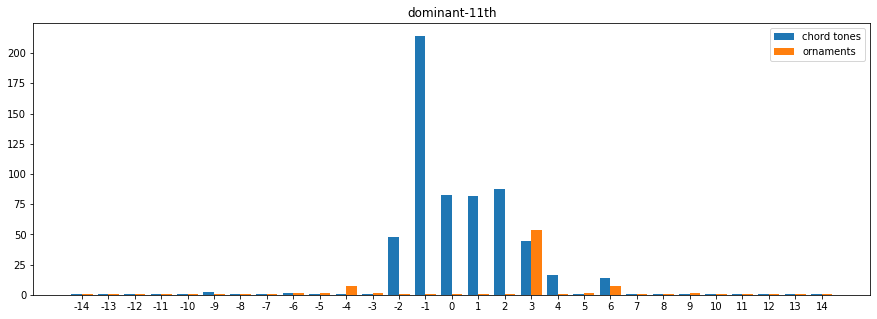

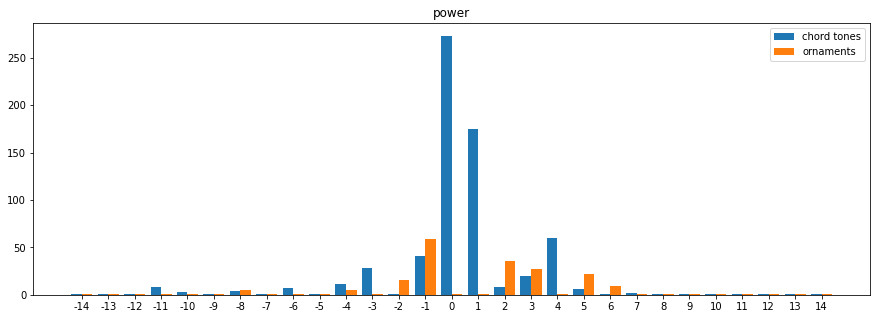

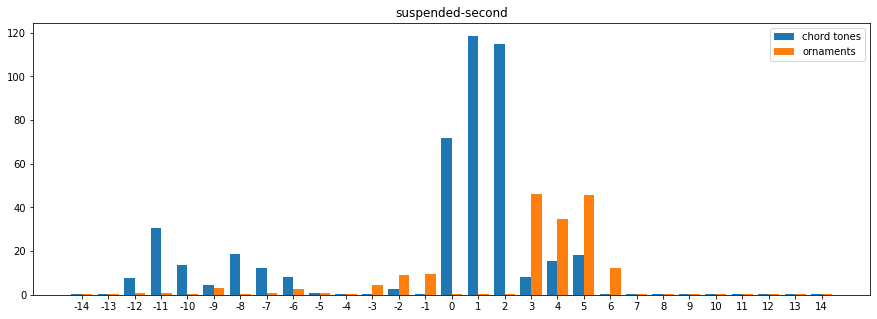

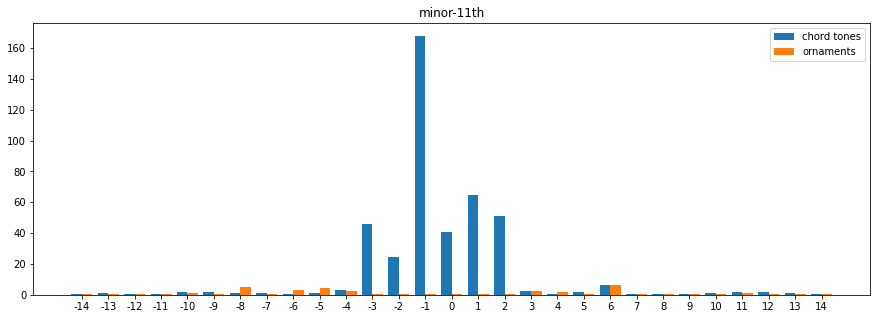

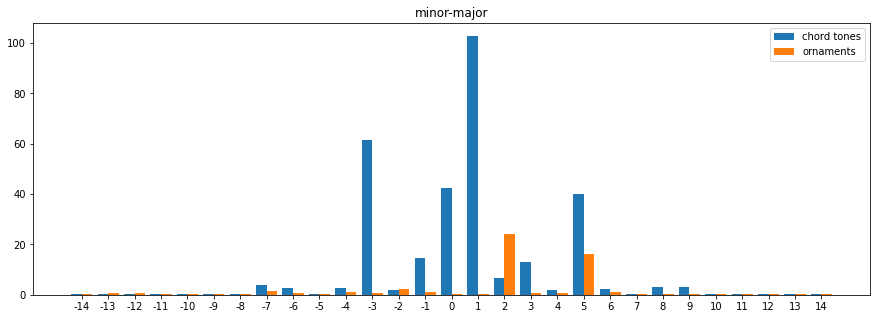

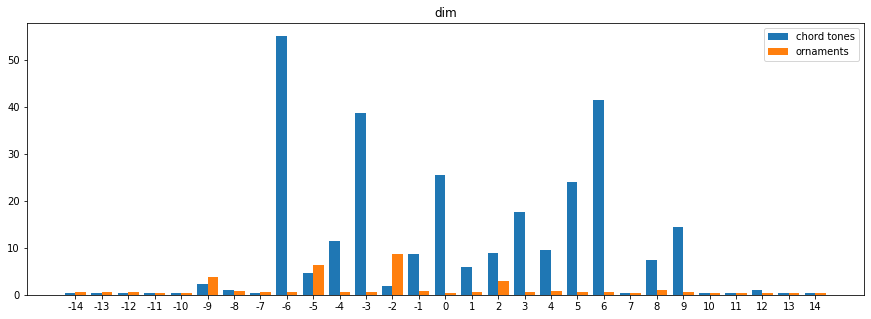

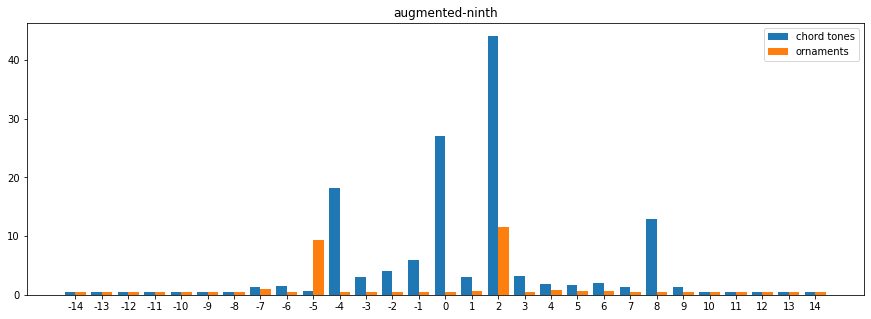

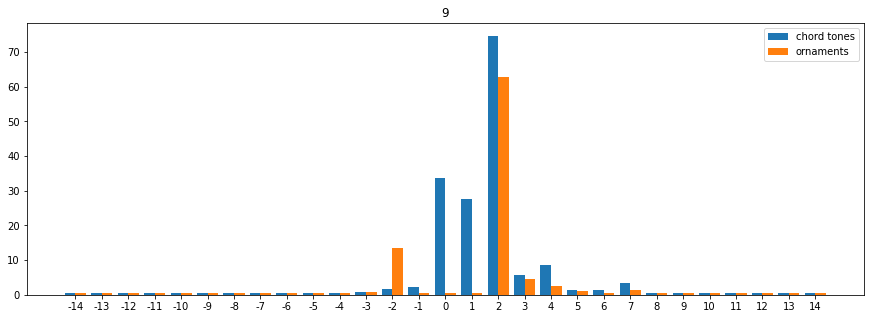

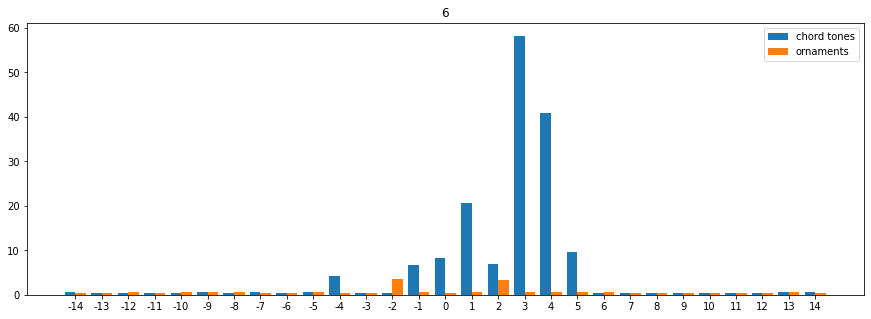

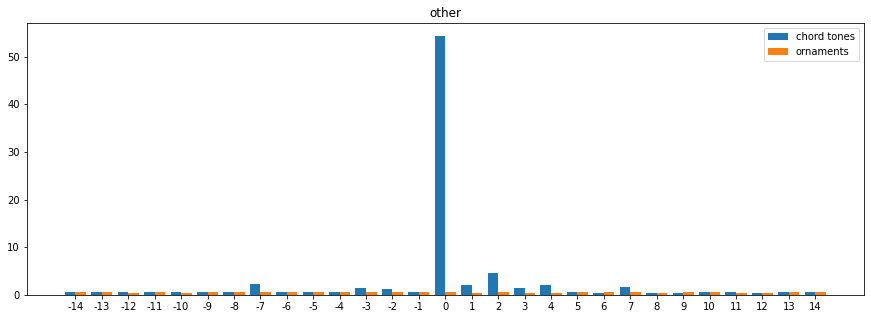

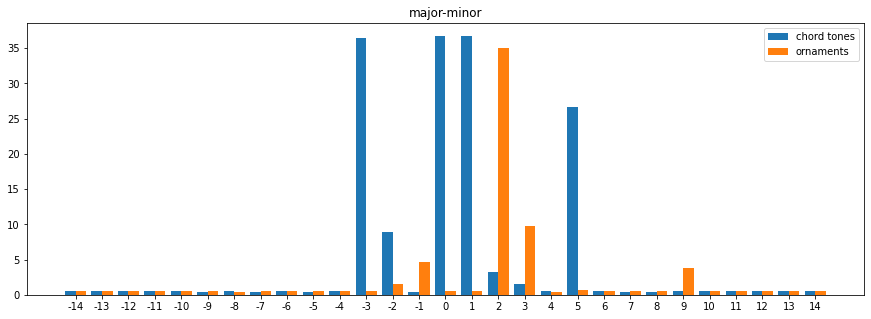

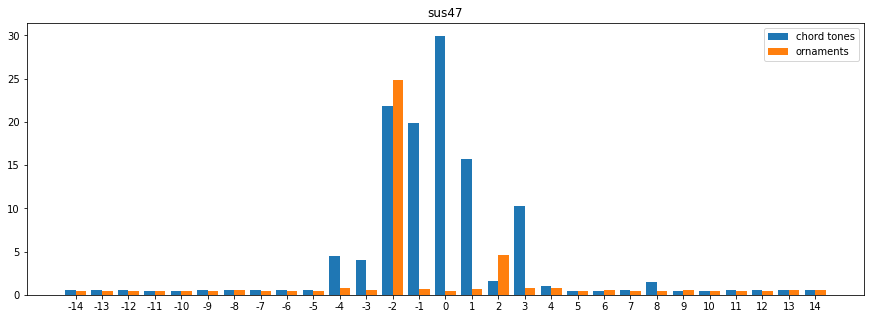

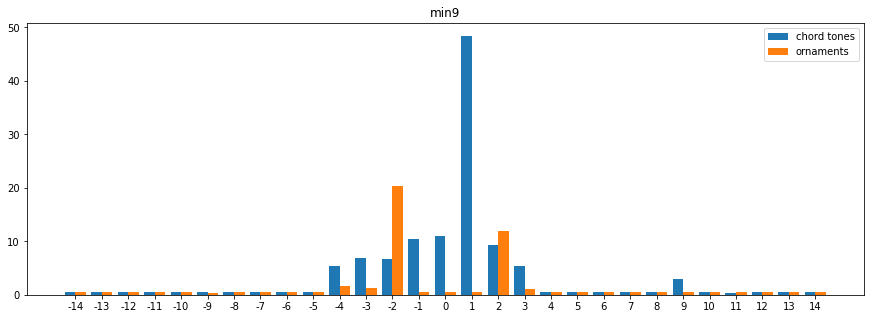

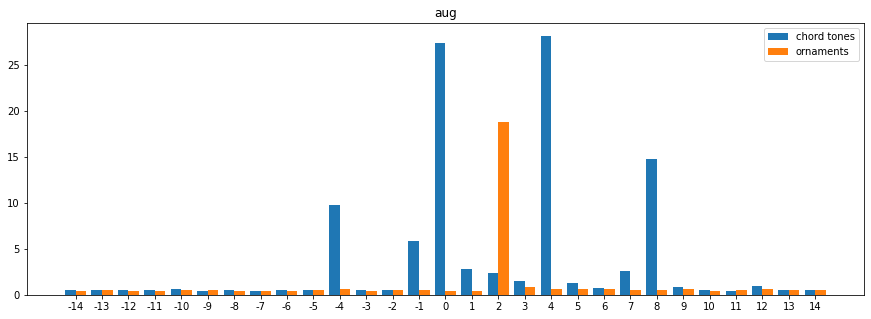

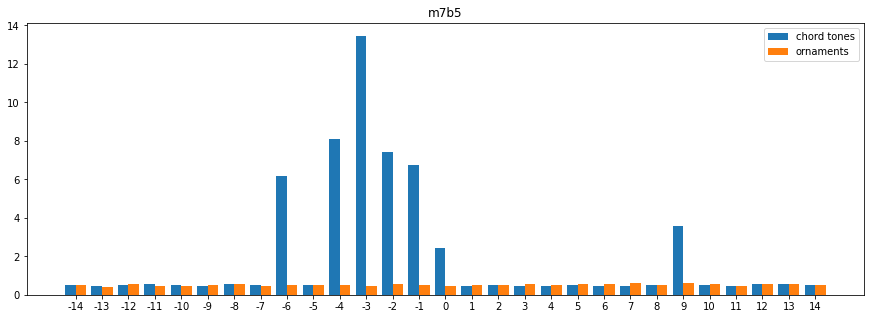

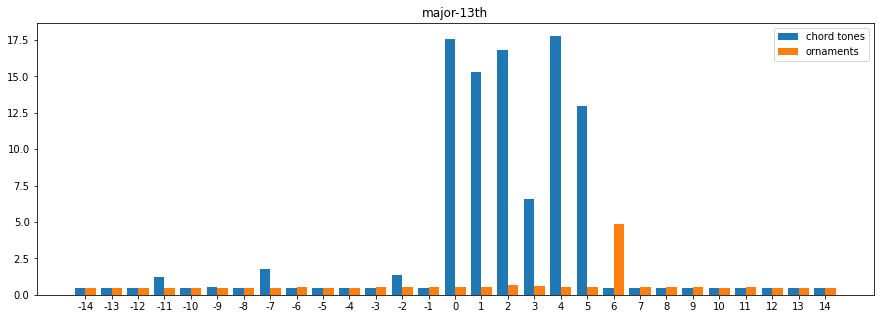

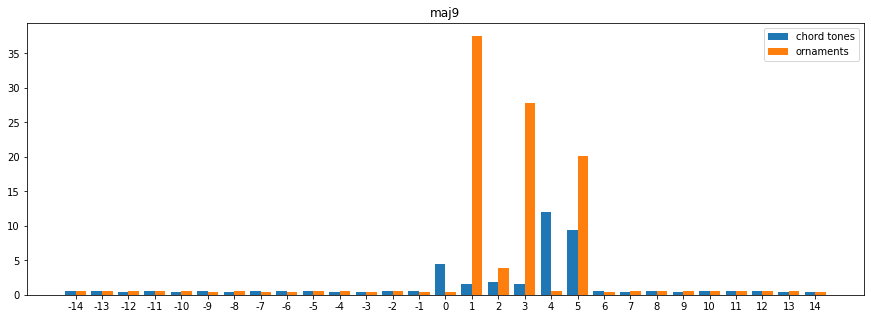

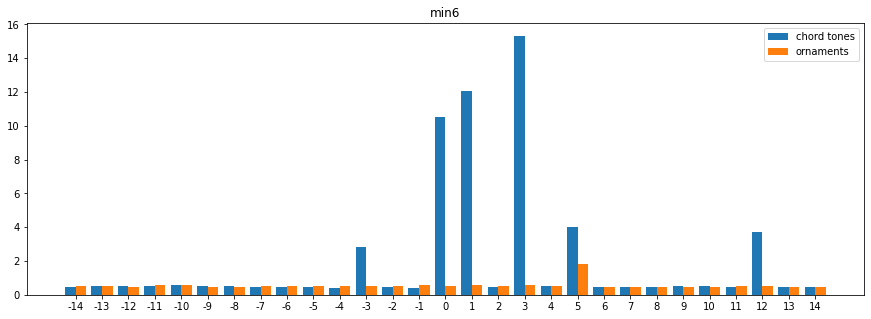

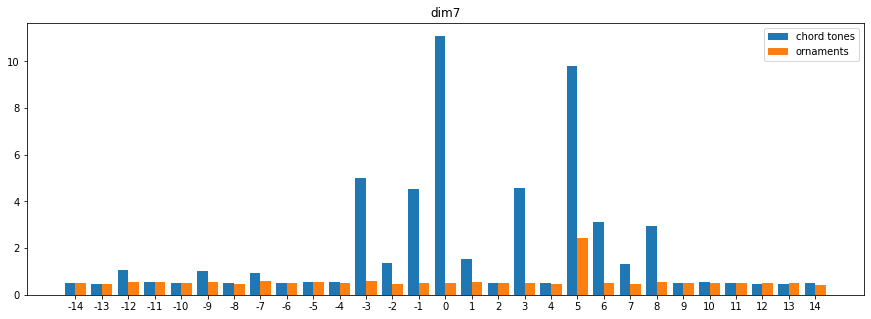

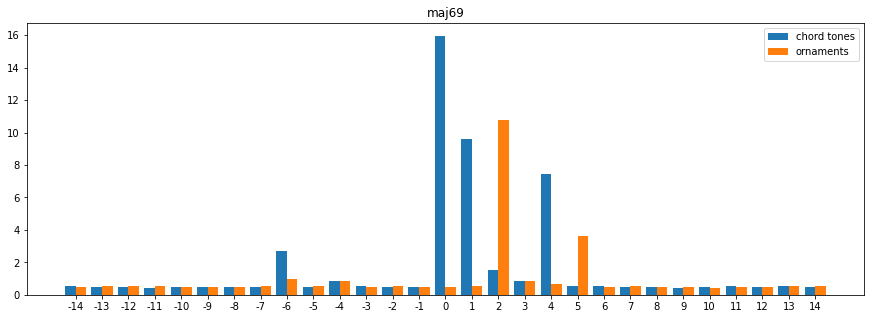

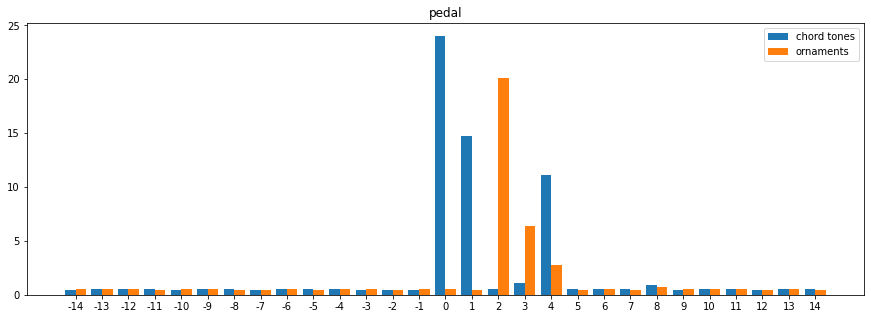

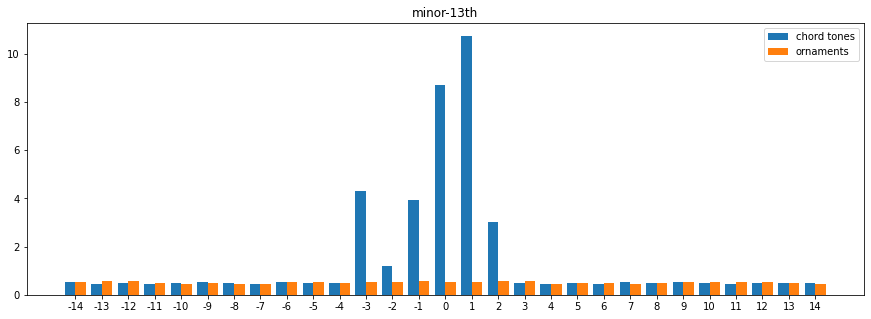

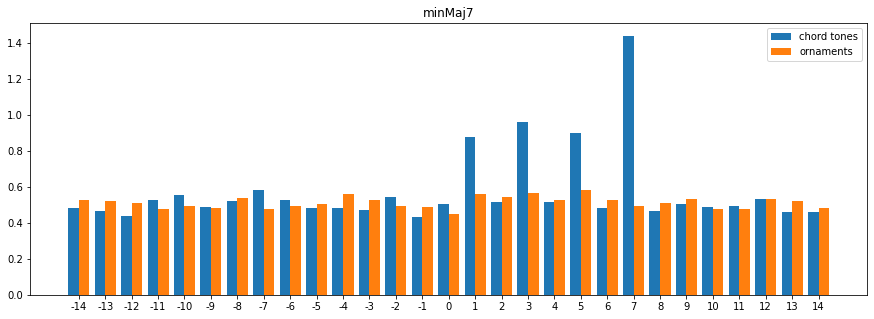

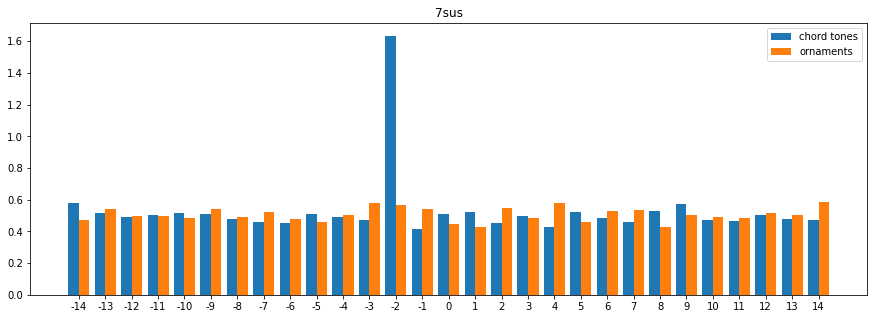

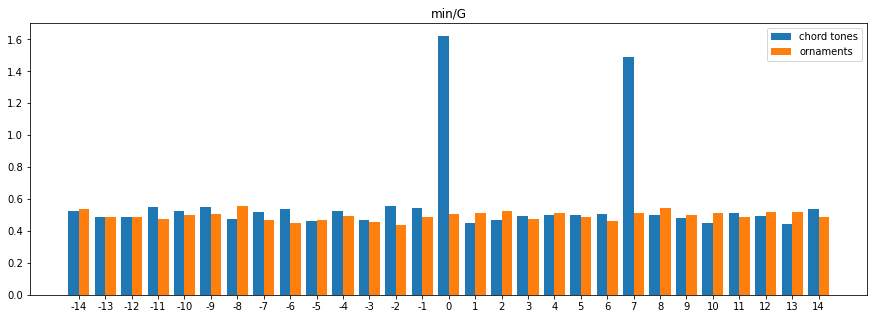

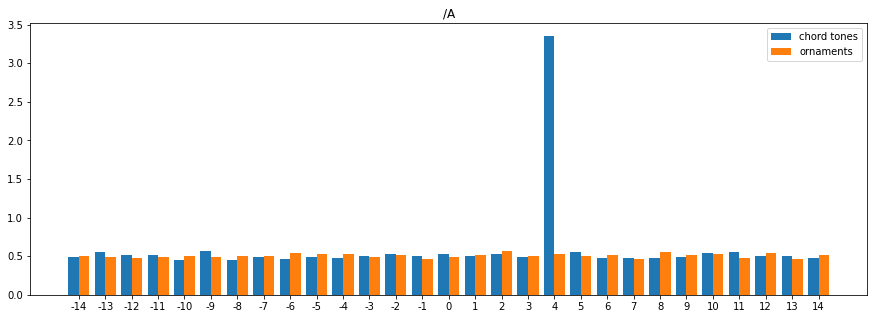

In [48]:
# plot the posterior distributions of the parameters
plot_posteriors(wiki_params, wiki_chordtypes)